In [1]:
from gurobipy import *
import pandas as pd
import numpy as np

In [2]:
# import Datasets
    ## from CElevts to LElevts by Trucks  e ,j
Cost_C_L = pd.read_csv('..\SYBM_Data_Cost&Production\CostByTruck.csv', index_col = 0).to_numpy()
    ## from LElevts to ETerminals by Barges j,k
Cost_L_E = pd.read_csv('..\SYBM_Data_Cost&Production\CostByBarge.csv', index_col = 0).to_numpy()
    ## from ETerminals to IChina by Ocean shipment k,m
Cost_E_I = pd.read_csv('..\SYBM_Data_Cost&Production\CostByOcean.csv', index_col = 0).to_numpy()
    ## from CElevts to Domestic Processing Facility C^P
Cost_E_F = pd.read_csv('..\SYBM_Data_Cost&Production\CostToFacility.csv', index_col = 0, usecols =['Name','Facility']).T.to_numpy()[0]
    ##E Country elevators hoding cost C^H
Cost_E_H = pd.read_csv('..\SYBM_Data_Cost&Production\CostToFacility.csv', index_col = 0, usecols =['Name','HoldingCost']).T.to_numpy()[0]
    ## Supply of each Country elevator
S = pd.read_csv('..\SYBM_Data_Cost&Production\ProductionByCountry.csv',index_col = 0,usecols=['Name','Production']).T.to_numpy()[0]
    ## Chian demand at year 2019
D = 88e6 
    ## last year inventory for each country elevator 2019
I_last = pd.read_csv('..\SYBM_Data_Cost&Production\ProductionByCountry.csv',index_col = 0,usecols=['Name','Ending']).T.to_numpy()[0]

In [3]:
T = 1   # Do not change! period year
Year = 2019

CElevts = Cost_C_L.shape[0] # number of Country elevators
LElevts = Cost_L_E.shape[0] # number of Larger elevators
ETerminals = Cost_E_I.shape[0] # number of export terminals
IChina = Cost_E_I.shape[1] # number of import terminals in China
Alpha = 0.9    # Inventory deterioration rate

#Dom_P =  200   # Domestic Soybean price
Beta1 = 315.948
Beta2 = 0
Beta3 = -4.43476   # Regression coefficients

#Glo_P =  400   # Global Soybean price
Gamma1 = 117.09
Gamma2 = 0
Gamma3 = 5.6e-6  # Regression coefficients

In [4]:
# Model
ModelName = "Soybean_V12_Jun-22-2021"
model = Model(ModelName)

Academic license - for non-commercial use only - expires 2021-07-27
Using license file C:\Users\heish\gurobi.lic


In [5]:
# Vars
x = model.addVars(CElevts, LElevts, lb=0, name="x_ejt")
I = model.addVars(CElevts, lb=0, name='I_et')
f = model.addVars(CElevts, lb=0, name='f_et')
y = model.addVars(LElevts, ETerminals, lb=0, name='y_jkt')
z = model.addVars(ETerminals, IChina, lb=0, name='z_kmt')
Dp= model.addVar(vtype=GRB.CONTINUOUS, name='DomesticP')
Gp= model.addVar(vtype=GRB.CONTINUOUS, name='GlobalP')
## Slack Vars
L = model.addVar(T, vtype=GRB.BINARY, name='L-Climate')
F = model.addVar(T, vtype=GRB.BINARY, name='F-GOVPolicy')

In [6]:
# add constraints 2
for e in range(CElevts):
    model.addConstr(Alpha*I_last[e] + S[e] == f[e] + I[e] + quicksum(x[e,j] for j in range(LElevts)))

C:\Users\heish\anaconda3\envs\gurobi\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# add Constraints 3
for j in range(LElevts):
    model.addConstr(quicksum(x[e,j] for e in range(CElevts)) == quicksum(y[j,k] for k in range(ETerminals)))

In [8]:
# add Constratints 4
for k in range(ETerminals):
    model.addConstr(quicksum(y[j,k] for j in range(LElevts)) == quicksum(z[k,m] for m in range(IChina)))

In [9]:
# add Constratints 5
model.addConstr(quicksum(z[k,m] for k in range(ETerminals)
                                for m in range(IChina)) <= D)

<gurobi.Constr *Awaiting Model Update*>

In [10]:
# add Constratints 6
model.addConstr(Dp == Beta1 + Beta2*L + Beta3*quicksum(I))

<gurobi.Constr *Awaiting Model Update*>

In [11]:
# add Constratints 7
model.addConstr(Gp == Gamma1 + Gamma2*F + Gamma3*quicksum(z))

<gurobi.Constr *Awaiting Model Update*>

In [12]:
# Obj
obj = LinExpr()
obj += quicksum((Gp-Cost_E_I[k,m])*z[k,m] for k in range(ETerminals) 
                                             for m in range(IChina))
obj -= quicksum(Cost_C_L[e,j]*x[e,j] for e in range(CElevts)
                                     for j in range(LElevts))
obj += quicksum((Dp-Cost_E_F[e])*f[e] for e in range(CElevts))
obj -= quicksum(Cost_E_H[e]*I[e] for e in range(CElevts))
obj -= quicksum(Cost_L_E[j,k]*y[j,k] for j in range(LElevts)
                                     for k in range(ETerminals))
model.setObjective(
    obj,
    GRB.MAXIMIZE
)

In [13]:
model.update()
model.params.NonConvex = 2
model.optimize()
model.write(ModelName+'.lp')

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 242 rows, 2752 columns and 5275 nonzeros
Model fingerprint: 0xdda29672
Model has 231 quadratic objective terms
Variable types: 2750 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [6e-06, 4e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 9e+07]
Presolve removed 0 rows and 2 columns
Presolve time: 0.01s
Presolved: 705 rows, 2982 columns, 6435 nonzeros
Presolved model has 231 bilinear constraint(s)
Variable types: 2982 continuous, 0 integer (0 binary)

Root relaxation: objective 4.418862e+10, 590 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

In [14]:
# Print solution
print('Number of variables: ' + str(model.getAttr("NumVars")))
print('Number of linear constraints: '+ str(model.getAttr("NumConstrs"))) 
print('Objective value for current solution: '+ str(model.getAttr("ObjVal"))) 

Number of variables: 2752
Number of linear constraints: 242
Objective value for current solution: 44188617457.51307


In [15]:
for var in model.getVars():
   print(f"{var.varName}: {round(var.X, 2)}")

x_ejt[0,0]: 0.0
x_ejt[0,1]: 0.0
x_ejt[0,2]: 0.0
x_ejt[0,3]: 0.0
x_ejt[0,4]: 0.0
x_ejt[0,5]: 0.0
x_ejt[0,6]: 0.0
x_ejt[0,7]: 426431.76
x_ejt[0,8]: 0.0
x_ejt[0,9]: 0.0
x_ejt[1,0]: 0.0
x_ejt[1,1]: 0.0
x_ejt[1,2]: 0.0
x_ejt[1,3]: 0.0
x_ejt[1,4]: 0.0
x_ejt[1,5]: 0.0
x_ejt[1,6]: 0.0
x_ejt[1,7]: 426431.76
x_ejt[1,8]: 0.0
x_ejt[1,9]: 0.0
x_ejt[2,0]: 0.0
x_ejt[2,1]: 0.0
x_ejt[2,2]: 0.0
x_ejt[2,3]: 0.0
x_ejt[2,4]: 0.0
x_ejt[2,5]: 0.0
x_ejt[2,6]: 0.0
x_ejt[2,7]: 426431.76
x_ejt[2,8]: 0.0
x_ejt[2,9]: 0.0
x_ejt[3,0]: 0.0
x_ejt[3,1]: 0.0
x_ejt[3,2]: 0.0
x_ejt[3,3]: 0.0
x_ejt[3,4]: 0.0
x_ejt[3,5]: 0.0
x_ejt[3,6]: 0.0
x_ejt[3,7]: 426431.76
x_ejt[3,8]: 0.0
x_ejt[3,9]: 0.0
x_ejt[4,0]: 0.0
x_ejt[4,1]: 0.0
x_ejt[4,2]: 0.0
x_ejt[4,3]: 0.0
x_ejt[4,4]: 0.0
x_ejt[4,5]: 0.0
x_ejt[4,6]: 0.0
x_ejt[4,7]: 426431.76
x_ejt[4,8]: 0.0
x_ejt[4,9]: 0.0
x_ejt[5,0]: 0.0
x_ejt[5,1]: 0.0
x_ejt[5,2]: 0.0
x_ejt[5,3]: 0.0
x_ejt[5,4]: 0.0
x_ejt[5,5]: 0.0
x_ejt[5,6]: 0.0
x_ejt[5,7]: 426431.76
x_ejt[5,8]: 0.0
x_ejt[5,9]: 0.0
x_ej

x_ejt[132,4]: 0.0
x_ejt[132,5]: 0.0
x_ejt[132,6]: 0.0
x_ejt[132,7]: 0.0
x_ejt[132,8]: 0.0
x_ejt[132,9]: 426431.76
x_ejt[133,0]: 0.0
x_ejt[133,1]: 0.0
x_ejt[133,2]: 0.0
x_ejt[133,3]: 0.0
x_ejt[133,4]: 0.0
x_ejt[133,5]: 0.0
x_ejt[133,6]: 0.0
x_ejt[133,7]: 0.0
x_ejt[133,8]: 0.0
x_ejt[133,9]: 426431.76
x_ejt[134,0]: 0.0
x_ejt[134,1]: 0.0
x_ejt[134,2]: 0.0
x_ejt[134,3]: 0.0
x_ejt[134,4]: 0.0
x_ejt[134,5]: 0.0
x_ejt[134,6]: 0.0
x_ejt[134,7]: 0.0
x_ejt[134,8]: 0.0
x_ejt[134,9]: 426431.76
x_ejt[135,0]: 0.0
x_ejt[135,1]: 0.0
x_ejt[135,2]: 0.0
x_ejt[135,3]: 0.0
x_ejt[135,4]: 0.0
x_ejt[135,5]: 0.0
x_ejt[135,6]: 0.0
x_ejt[135,7]: 0.0
x_ejt[135,8]: 0.0
x_ejt[135,9]: 426431.76
x_ejt[136,0]: 0.0
x_ejt[136,1]: 0.0
x_ejt[136,2]: 0.0
x_ejt[136,3]: 0.0
x_ejt[136,4]: 0.0
x_ejt[136,5]: 0.0
x_ejt[136,6]: 0.0
x_ejt[136,7]: 0.0
x_ejt[136,8]: 0.0
x_ejt[136,9]: 426431.76
x_ejt[137,0]: 0.0
x_ejt[137,1]: 0.0
x_ejt[137,2]: 0.0
x_ejt[137,3]: 0.0
x_ejt[137,4]: 0.0
x_ejt[137,5]: 0.0
x_ejt[137,6]: 0.0
x_ejt[137,7]: 0.

x_ejt[182,3]: 0.0
x_ejt[182,4]: 0.0
x_ejt[182,5]: 0.0
x_ejt[182,6]: 0.0
x_ejt[182,7]: 0.0
x_ejt[182,8]: 0.0
x_ejt[182,9]: 0.0
x_ejt[183,0]: 0.0
x_ejt[183,1]: 0.0
x_ejt[183,2]: 0.0
x_ejt[183,3]: 0.0
x_ejt[183,4]: 0.0
x_ejt[183,5]: 0.0
x_ejt[183,6]: 426431.76
x_ejt[183,7]: 0.0
x_ejt[183,8]: 0.0
x_ejt[183,9]: 0.0
x_ejt[184,0]: 0.0
x_ejt[184,1]: 0.0
x_ejt[184,2]: 0.0
x_ejt[184,3]: 0.0
x_ejt[184,4]: 0.0
x_ejt[184,5]: 0.0
x_ejt[184,6]: 0.0
x_ejt[184,7]: 0.0
x_ejt[184,8]: 0.0
x_ejt[184,9]: 0.0
x_ejt[185,0]: 0.0
x_ejt[185,1]: 0.0
x_ejt[185,2]: 0.0
x_ejt[185,3]: 0.0
x_ejt[185,4]: 0.0
x_ejt[185,5]: 0.0
x_ejt[185,6]: 426431.76
x_ejt[185,7]: 0.0
x_ejt[185,8]: 0.0
x_ejt[185,9]: 0.0
x_ejt[186,0]: 0.0
x_ejt[186,1]: 0.0
x_ejt[186,2]: 0.0
x_ejt[186,3]: 0.0
x_ejt[186,4]: 0.0
x_ejt[186,5]: 0.0
x_ejt[186,6]: 426431.76
x_ejt[186,7]: 0.0
x_ejt[186,8]: 0.0
x_ejt[186,9]: 0.0
x_ejt[187,0]: 0.0
x_ejt[187,1]: 0.0
x_ejt[187,2]: 0.0
x_ejt[187,3]: 0.0
x_ejt[187,4]: 0.0
x_ejt[187,5]: 0.0
x_ejt[187,6]: 426431.76
x_ej

I_et[52]: 0.0
I_et[53]: 0.0
I_et[54]: 0.0
I_et[55]: 0.0
I_et[56]: 0.0
I_et[57]: 0.0
I_et[58]: 0.0
I_et[59]: 0.0
I_et[60]: 0.0
I_et[61]: 0.0
I_et[62]: 0.0
I_et[63]: 0.0
I_et[64]: 0.0
I_et[65]: 0.0
I_et[66]: 0.0
I_et[67]: 0.0
I_et[68]: 0.0
I_et[69]: 0.0
I_et[70]: 0.0
I_et[71]: 0.0
I_et[72]: 0.0
I_et[73]: 0.0
I_et[74]: 0.0
I_et[75]: 0.0
I_et[76]: 0.0
I_et[77]: 0.0
I_et[78]: 0.0
I_et[79]: 0.0
I_et[80]: 0.0
I_et[81]: 0.0
I_et[82]: 0.0
I_et[83]: 0.0
I_et[84]: 0.0
I_et[85]: 0.0
I_et[86]: 0.0
I_et[87]: 0.0
I_et[88]: 0.0
I_et[89]: 0.0
I_et[90]: 0.0
I_et[91]: 0.0
I_et[92]: 0.0
I_et[93]: 0.0
I_et[94]: 0.0
I_et[95]: 0.0
I_et[96]: 0.0
I_et[97]: 0.0
I_et[98]: 0.0
I_et[99]: 0.0
I_et[100]: 0.0
I_et[101]: 0.0
I_et[102]: 0.0
I_et[103]: 0.0
I_et[104]: 0.0
I_et[105]: 0.0
I_et[106]: 0.0
I_et[107]: 0.0
I_et[108]: 0.0
I_et[109]: 0.0
I_et[110]: 0.0
I_et[111]: 0.0
I_et[112]: 0.0
I_et[113]: 0.0
I_et[114]: 0.0
I_et[115]: 0.0
I_et[116]: 0.0
I_et[117]: 0.0
I_et[118]: 0.0
I_et[119]: 0.0
I_et[120]: 0.0
I_et[121]: 0.

In [16]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

Var_X = pd.DataFrame(0,index=range(CElevts),columns=range(LElevts))
for i in range(CElevts):
    for j in range(LElevts):
        Var_X.iloc[i,j] = x[i,j].X
Var_X

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0.000,426431.765,0,0.000
1,0,0,0,0,0,0,0.000,426431.765,0,0.000
2,0,0,0,0,0,0,0.000,426431.765,0,0.000
3,0,0,0,0,0,0,0.000,426431.765,0,0.000
4,0,0,0,0,0,0,0.000,426431.765,0,0.000
5,0,0,0,0,0,0,0.000,426431.765,0,0.000
6,0,0,0,0,0,0,0.000,426431.765,0,0.000
7,0,0,0,0,0,0,0.000,426431.765,0,0.000
8,0,0,0,0,0,0,0.000,426431.765,0,0.000
9,0,0,0,0,0,0,0.000,426431.765,0,0.000


In [17]:
Var_Y = pd.DataFrame(0,index=range(LElevts),columns=range(ETerminals))
for i in range(LElevts):
    for j in range(ETerminals):
        Var_Y.iloc[i,j] = y[i,j].X
Var_Y

,0,1
0,0.000000e+00,0
1,0.000000e+00,0
2,0.000000e+00,0
3,0.000000e+00,0
4,0.000000e+00,0
5,0.000000e+00,0
6,3.368811e+07,0
7,4.962114e+07,0
8,0.000000e+00,0
9,4.690749e+06,0


In [18]:
Var_z = pd.DataFrame(0,index=range(ETerminals),columns=range(IChina))
for i in range(ETerminals):
    for j in range(IChina):
        Var_z.iloc[i,j] = z[i,j].X
Var_z

,0,1
0,0,88000000
1,0,0


In [19]:
Var_I = pd.DataFrame(0,index=range(CElevts),columns=[0])
for i in range(CElevts):
    Var_I.iloc[i,0] = I[i].X
Var_I

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [20]:
Var_f = pd.DataFrame(0,index=range(CElevts),columns=[0])
for i in range(CElevts):
    Var_f.iloc[i,0] = f[i].X
Var_f

,0
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,0.000
6,0.000
7,0.000
8,0.000
9,0.000


<AxesSubplot:>

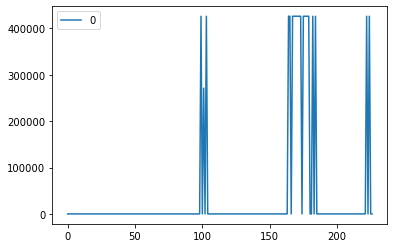

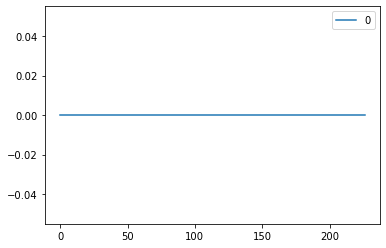

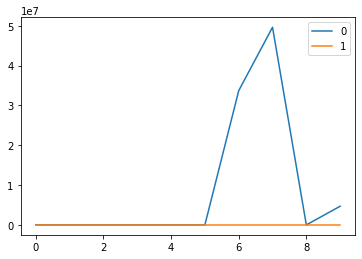

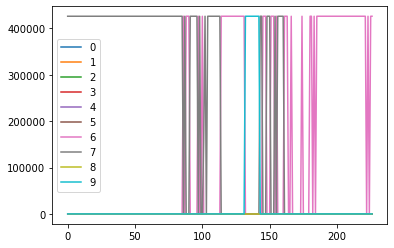

In [21]:
%matplotlib inline
Var_f.plot()
Var_I.plot()
Var_Y.plot()
Var_X.plot()